Timeseries transformer features
--------------------------------------

Combination of yearly and monthly country-level macroeconomic indicator variables. For the first iteration of the timeseries transformer, only developed wealthy countries with similar development trajectories over the post-WWII period were selected. This should allow the model to learn patterns easier. In order to combine monthly and yearly observations, the yearly observation is repeated over the 12-month period following the measurement point.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

Load and reshape the selected country-level indicator datasets. 

In [3]:
countries = ['Canada', 'Denmark', 'France', 'Germany', 'Japan', 'Netherlands', 'Norway', 'Singapore', 'Sweden',
             'Switzerland', 'United Kingdom', 'United States']

In order to check the availability of key indicator variables, the notebook needs to be ran manually for each of the countries in the country group.

In [4]:
country = 'United States'

In [5]:
pop_df = pd.read_csv('data/people.csv', sep=';')
pop_df = pop_df[pop_df['country'] == country]
pop_pivot_df = pop_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
population_df = pop_pivot_df.iloc[:, pop_pivot_df.columns.get_level_values(1) == 'Population, total'].stack('country').fillna(0.00)
population_df['population'] = population_df['Population, total']

In [6]:
gdp_read_df = pd.read_csv('data/policy.csv', sep=';')
gdp_read_df = gdp_read_df[gdp_read_df['country'] == country]
gdp_pivot_df = gdp_read_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
gdp_df = gdp_pivot_df.iloc[:, gdp_pivot_df.columns.get_level_values(1) == 'GDP (constant 2010 US$)'].stack('country').fillna(0.00)
gdp_df['gdp'] = gdp_df['GDP (constant 2010 US$)']

In [7]:
gni_read_df = pd.read_csv('data/policy.csv', sep=';')
gni_read_df = gni_read_df[gni_read_df['country'] == country]
gni_pivot_df = gni_read_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
gni_df = gni_pivot_df.iloc[:, gni_pivot_df.columns.get_level_values(1) == 'GNI (constant 2010 US$)'].stack('country').fillna(0.00)
gni_df['gni'] = gni_df['GNI (constant 2010 US$)']

## People

In [8]:
consumption_df = pd.read_csv('data/trade.csv', sep=';')
consumption_df = consumption_df[consumption_df['country'] == country]
consumption_pivot_df = consumption_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
household_df = consumption_pivot_df.iloc[:, consumption_pivot_df.columns.get_level_values(1) == 'Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'].stack('country')

In [9]:
people_df = pd.read_csv('data/people.csv', sep=';')
people_df = people_df[people_df['country'] == country]
peoples_pivot_df = people_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
peoples_index_df = pd.concat([peoples_pivot_df.stack('country'), gdp_df, gni_df, household_df], axis=1).sort_index().fillna(0.00)
peoples_index_df.columns

Index(['Birth rate, crude (per 1,000 people)',
       'Consumer Price Index, All items',
       'Consumer Price Index, All items, Percentage change, Previous period',
       'Education, Weight, Percent',
       'Fertility rate, total (births per woman)',
       'Final consumption expenditure (annual % growth)',
       'Food and non-alcoholic beverages, Weight, Percent',
       'Health, Weight, Percent',
       'Housing, Water, Electricity, Gas and Other Fuels, Weight, Percent',
       'Inflation, consumer prices (annual %)',
       'Informal employment (% of total non-agricultural employment)',
       'Labor Force, Persons, Number of',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Population ages 15-64 (% of total)',
       'Population density (people per sq. km of land area)',
       'Population growth (annual %)', 'Population, total',
       'Prevalence of overweight (% of adults)',
       'Recreation and culture, W

In [10]:
peoples_features = ['newborns', 'birth deaths', 'life expectancy', 'rural population', 'urban population',
                    'overweight', 'population density', 'housing expenditure', 'health expenditure',
                    'food expenditure', 'transportation expenditure', 'education expenditure', 'leisure expenditure']

#### People features

- **newborns**: number of newborn infants.
- **birth deaths**: number of deaths in live births.
- **life expectancy**: life expectancy at birth in years.
- **rural population**: number of people living in a rural setting. 
- **urban population**: number of people living in an urban setting.
- **workers**: size of the nation's labor force.
- **unemployed**: number of unemployed.
- **overweight**: number adults in the population that are overweight.
- **population density**: 1000 persons per sq. km of land area
- **housing expenditure**: expenditure on housing in 2010 USD.
- **health expenditure**: expenditure on health in 2010 USD.
- **food expenditure**: expenditure on housing in 2010 USD.
- **transportation expenditure**: expenditure on health in 2010 USD.
- **education expenditure**: expenditure on housing in 2010 USD.
- **leisure expenditure**: expenditure on health in 2010 USD.

In [11]:
peoples_index_df['newborns'] = (peoples_index_df['Population, total'] / 1000) * peoples_index_df['Birth rate, crude (per 1,000 people)']
peoples_index_df['birth deaths'] = peoples_index_df['newborns'] * (peoples_index_df['Mortality rate, infant (per 1,000 live births)'] / 100)

In [12]:
peoples_index_df['life expectancy'] = peoples_index_df['Life expectancy at birth, total (years)'] / 100
peoples_index_df['population density'] = peoples_index_df['Population density (people per sq. km of land area)'] / 1000

In [13]:
peoples_index_df['rural population'] = (peoples_index_df['Rural population (% of total population)'] / 100) * peoples_index_df['Population, total'] 
peoples_index_df['urban population'] = (peoples_index_df['Urban population (% of total)'] / 100) * peoples_index_df['Population, total']

In [14]:
peoples_index_df['overweight'] = (peoples_index_df['Population ages 15-64 (% of total)'] / 100) * (peoples_index_df['Prevalence of overweight (% of adults)'] / 100) * peoples_index_df['Population, total']

In [15]:
if country in countries:
    peoples_index_df['housing expenditure'] = (peoples_index_df['Housing, Water, Electricity, Gas and Other Fuels, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
    peoples_index_df['health expenditure'] = (peoples_index_df['Health, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
    peoples_index_df['food expenditure'] = (peoples_index_df['Food and non-alcoholic beverages, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
    peoples_index_df['transportation expenditure'] = (peoples_index_df['Transport, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
    peoples_index_df['education expenditure'] = (peoples_index_df['Education, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
    peoples_index_df['leisure expenditure'] = (peoples_index_df['Recreation and culture, Weight, Percent'] / 100) * peoples_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * peoples_index_df['Population, total']
else:
    pass

In [16]:
if country in countries:
    peoples_features_df = peoples_index_df[peoples_features]
else:
    peoples_reduced_features = ['newborns', 'birth deaths', 'life expectancy', 'rural population', 
                                'urban population', 'overweight', 'population density']
    peoples_features_df = peoples_index_df[peoples_reduced_features]

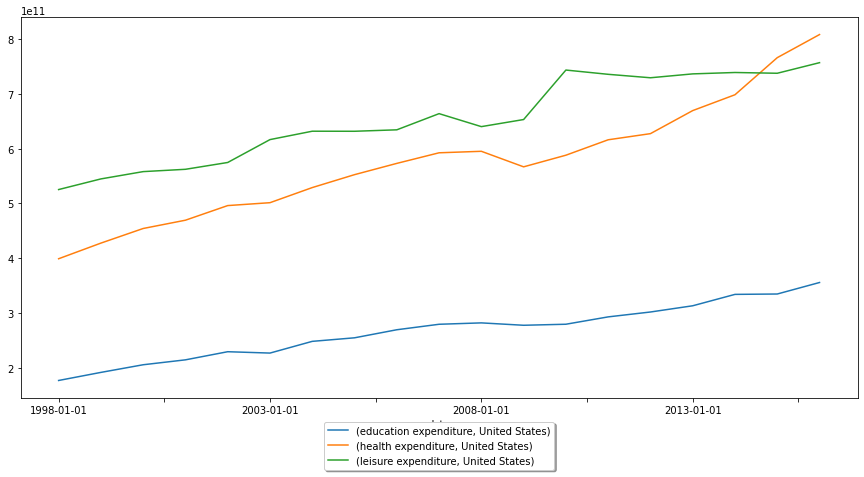

In [17]:
if country in countries:
    peoples_plots_df = peoples_features_df[['education expenditure', 'health expenditure', 'leisure expenditure']].unstack()
    peoples_plots_df = peoples_plots_df[(peoples_plots_df.T != 0.00).any()]
    fig, ax = plt.subplots(figsize=(15,7))
    peoples_plots_df.iloc[:, peoples_plots_df.columns.get_level_values(1).isin([country])].dropna().plot(kind='line', ax=ax)
    plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, shadow = True)
else:
    peoples_plots_df = peoples_features_df[['birth deaths']].unstack()
    fig, ax = plt.subplots(figsize=(15,7))
    peoples_plots_df.iloc[:, peoples_plots_df.columns.get_level_values(1).isin([country])].dropna().plot(kind='line', ax=ax)
    plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, shadow = True)

## Technology

In [18]:
tech_df = pd.read_csv('data/tech.csv', sep=';')
tech_df = tech_df[tech_df['country'] == country]
tech_pivot_df = tech_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
tech_index_df = pd.concat([tech_pivot_df.stack('country'), population_df, gdp_df, gni_df], axis=1).sort_index().fillna(0.00)
tech_index_df.columns

Index(['Access to electricity (% of population)',
       'CO2 emissions (metric tons per capita)',
       'Cereal yield (kg per hectare)',
       'Electric power consumption (kWh per capita)',
       'Fertilizer consumption (kilograms per hectare of arable land)',
       'Fixed broadband subscriptions (per 100 people)',
       'Industry (including construction), value added per worker (constant 2010 US$)',
       'Manufacturing, value added (% of GDP)',
       'Manufacturing, value added (annual % growth)',
       'Medium and high-tech Industry (including construction) (% manufacturing value added)',
       'Mobile cellular subscriptions (per 100 people)',
       'Research and development expenditure (% of GDP)', 'Population, total',
       'population', 'GDP (constant 2010 US$)', 'gdp',
       'GNI (constant 2010 US$)', 'gni'],
      dtype='object', name='indicator')

In [19]:
tech_features = ['electricity access', 'electricity consumption', 'co2 emissions', 'broadband subscriptions',
                 'mobile subscriptions', 'manufacturing value added', 'high-tech value added', 'r and d spend',
                 'cereal yield']

#### Tech features

- **electricity access**: number of people with electricity access.
- **electricity consumption**: MWh consumed per year.
- **c02 emissions**: metric tons of CO2 emitted.
- **broadband subscriptions**: number of broadband subscriptions.
- **mobile subscriptions**: number of mobile subscriptions.
- **manufacturing value added**: manufacturing value added in 2010 USD.
- **high-tech value added**: high-tech industry value added in 2010 USD.
- **r and d spend**: country r and d spend.
- **cereal yield**: 1000 kg per hectare.

In [20]:
tech_index_df['manufacturing value added'] = ((tech_index_df['Manufacturing, value added (% of GDP)'] / 100) * tech_index_df['GDP (constant 2010 US$)'])
tech_index_df['high-tech value added'] = (((tech_index_df['Manufacturing, value added (% of GDP)'] / 100) * tech_index_df['GDP (constant 2010 US$)']) * (tech_index_df['Medium and high-tech Industry (including construction) (% manufacturing value added)'] / 100))

In [21]:
tech_index_df['electricity access'] = (tech_index_df['Access to electricity (% of population)'] / 100) * tech_index_df['Population, total']

In [22]:
tech_index_df['broadband subscriptions'] = tech_index_df['Fixed broadband subscriptions (per 100 people)'] * (tech_index_df['Population, total'] / 100)
tech_index_df['mobile subscriptions'] = tech_index_df['Mobile cellular subscriptions (per 100 people)'] * (tech_index_df['Population, total'] / 100)

In [23]:
tech_index_df['electricity consumption'] = (tech_index_df['Electric power consumption (kWh per capita)'] / 1000) * tech_index_df['Population, total']
tech_index_df['co2 emissions'] = tech_index_df['CO2 emissions (metric tons per capita)'] * tech_index_df['Population, total']
tech_index_df['r and d spend'] = (tech_index_df['Research and development expenditure (% of GDP)'] / 100) * tech_index_df['GDP (constant 2010 US$)']
tech_index_df['cereal yield'] = tech_index_df['Cereal yield (kg per hectare)'] / 1000

In [24]:
tech_features_df = tech_index_df[tech_features]

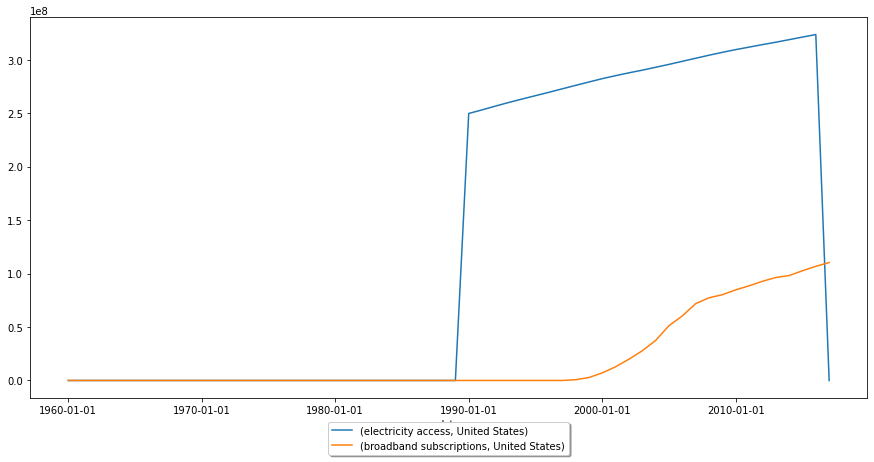

In [25]:
tech_plot_df = tech_features_df[['electricity access', 'broadband subscriptions']].unstack()
fig, ax = plt.subplots(figsize=(15,7))
tech_plot_df.iloc[:, tech_plot_df.columns.get_level_values(1).isin([country])].dropna().plot(kind='line', ax=ax)
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, shadow = True)

## Trade

In [26]:
trade_df = pd.read_csv('data/trade.csv', sep=';')
trade_df = trade_df[trade_df['country'] == country]
trade_pivot_df = trade_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
trade_index_df = pd.concat([trade_pivot_df.stack('country'), population_df, gdp_df, gni_df], axis=1).sort_index().fillna(0.00)
trade_index_df.columns

Index(['Energy imports, net (% of energy use)',
       'Exports of goods and services (% of GDP)',
       'Exports of goods and services (constant 2010 US$)',
       'Food exports (% of merchandise exports)',
       'Food imports (% of merchandise imports)',
       'GNI per capita (constant 2010 US$)',
       'High-technology exports (% of manufactured exports)',
       'Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)',
       'Imports of goods and services (% of GDP)',
       'Imports of goods and services (constant 2010 US$)',
       'Manufacturing, value added (% of GDP)',
       'Manufacturing, value added (constant 2010 US$)', 'Trade (% of GDP)',
       'Trade in services (% of GDP)', 'Population, total', 'population',
       'GDP (constant 2010 US$)', 'gdp', 'GNI (constant 2010 US$)', 'gni'],
      dtype='object', name='indicator')

In [27]:
trade_features = ['imports of goods and services', 'exports of goods and services', 'energy imports', 
                  'high-tech exports', 'food exports', 'services trade', 'trade', 'household consumption expenditure']

#### Trade features

- **imports of goods and services**: the imports of goods and services in 2010 USD.
- **exports of goods and services**: the exports of goods and services in 2010 USD.
- **energy imports**: percentage of energy used that was imported.
- **high-tech exports**: percentage of manufactures consisting of high tech goods.
- **food exports**: percentage of merchandise exports consisting of foodstuff.
- **food imports**: percentage of merchandise imports consisting of foodstuff.
- **services trade**: trade in services in 2010 USD.
- **trade**: trade volumes in 2010 USD.
- **household consumption expenditure**: household consumption expenditure in 2010 USD.

In [28]:
trade_index_df['imports of goods and services'] = trade_index_df['Imports of goods and services (constant 2010 US$)']
trade_index_df['exports of goods and services'] = trade_index_df['Exports of goods and services (constant 2010 US$)']

In [29]:
trade_index_df['energy imports'] = trade_index_df['Energy imports, net (% of energy use)'] / 100
trade_index_df['high-tech exports'] = trade_index_df['High-technology exports (% of manufactured exports)'] / 100
trade_index_df['food exports'] = trade_index_df['Food exports (% of merchandise exports)'] / 100
trade_index_df['food imports'] = trade_index_df['Food imports (% of merchandise imports)'] / 100
trade_index_df['household consumption expenditure'] = trade_index_df['Households and NPISHs Final consumption expenditure per capita (constant 2010 US$)'] * trade_index_df['Population, total']

In [30]:
trade_index_df['services trade'] = (trade_index_df['Trade in services (% of GDP)'] / 100) * trade_index_df['GDP (constant 2010 US$)']
trade_index_df['trade'] = (trade_index_df['Trade (% of GDP)'] / 100) * trade_index_df['GDP (constant 2010 US$)']

In [31]:
trade_features_df = trade_index_df[trade_features]

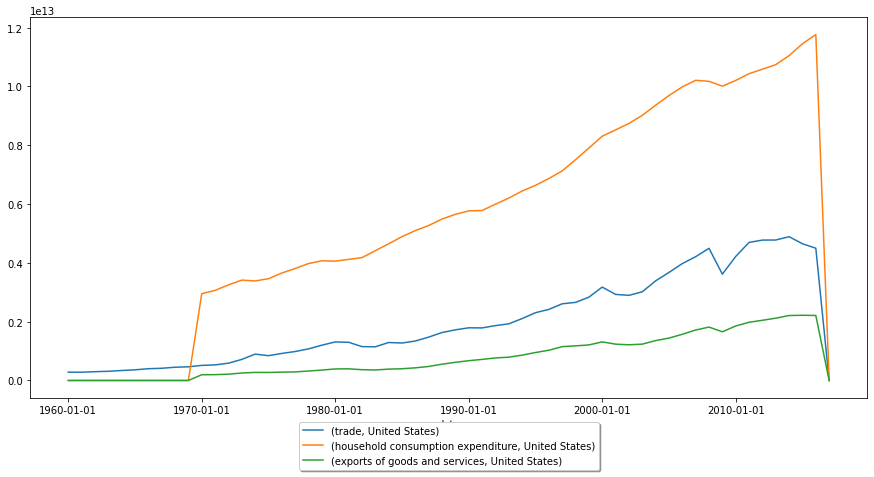

In [32]:
trade_plot_df = trade_features_df[['trade', 'household consumption expenditure', 'exports of goods and services']].unstack()
fig, ax = plt.subplots(figsize=(15,7))
trade_plot_df.iloc[:, trade_plot_df.columns.get_level_values(1).isin([country])].dropna().plot(kind='line', ax=ax)
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, shadow = True)

## Policy

In [33]:
policy_df = pd.read_csv('data/policy.csv', sep=';')
polciy_df = policy_df[policy_df['country'] == country]
policy_pivot_df = policy_df.pivot_table(index='date', columns=['country', 'indicator'], values='value').drop_duplicates()
policy_index_df = pd.concat([policy_pivot_df.stack('country'), population_df], axis=1).sort_index().fillna(0.00)
policy_index_df.columns

Index(['Bank capital to assets ratio (%)',
       'Bank nonperforming loans to total gross loans (%)',
       'Broad money (% of GDP)', 'Central government debt, total (% of GDP)',
       'Compensation of employees (% of expense)',
       'Firms using banks to finance investment (% of firms)',
       'GDP (constant 2010 US$)', 'GDP growth (annual %)',
       'GDP per capita growth (annual %)', 'GNI (constant 2010 US$)',
       'GNI growth (annual %)', 'GNI per capita growth (annual %)',
       'Gross domestic savings (% of GDP)', 'Gross savings (% of GNI)',
       'Inflation, GDP deflator (annual %)',
       'Interest payments (% of expense)',
       'Interest payments on external debt (% of GNI)',
       'Lending interest rate (%)',
       'Market capitalization of listed domestic companies (% of GDP)',
       'Real interest rate (%)', 'Short-term debt (% of total external debt)',
       'Tax revenue (% of GDP)', 'Total debt service (% of GNI)',
       'Total reserves (% of total exte

In [34]:
policy_features = ['bank capital to assets ratio', 'bank nonperforming loans', 'lending interest rate',
                   'real interest rate', 'gross domestic savings',  'broad money', 'government debt',
                   'government interest payments external debt', 'government tax revenue', 'government debt service', 
                   'gdp', 'gni', 'inflation', 'listed companies']

#### Policy features

- **bank capital to assets ratio**: (sic), commercial banks.
- **bank nonperforming loans**: commercial bank nonperforming loans percentage.
- **lending interest rate**: average commercial bank lending interest rate.
- **real interest rate**: interest rate in percentages.
- **gross domestic savings**: gross domestic savings in 2010 USD.
- **listed companies**: market capitalization of listed companies in 2010 USD.
- **broad money**: amount of broad money present in the economy in 2010 USD.
- **government debt**: amount of outstanding government debt in 2010 USD.
- **government interest payments external debt**: interest payments on external debt in 2010 USD.
- **tax revenue**: government tax revenue in 2010 USD.
- **total debt service**: government total debt service in 2010 USD.
- **gdp**: gross domestic product in 2010 USD.
- **gni**: gross national product in 2010 USD.
- **inflation**: annual inflation.

In [35]:
policy_index_df['bank capital to assets ratio'] = policy_index_df['Bank capital to assets ratio (%)'] / 100
policy_index_df['bank nonperforming loans'] = policy_index_df['Bank nonperforming loans to total gross loans (%)'] / 100
policy_index_df['lending interest rate'] = policy_index_df['Lending interest rate (%)'] / 100
policy_index_df['real interest rate'] = policy_index_df['Real interest rate (%)'] / 100
policy_index_df['inflation'] = policy_index_df['Inflation, GDP deflator (annual %)'] / 100

In [36]:
policy_index_df['gdp'] = policy_index_df['GDP (constant 2010 US$)']
policy_index_df['gni'] = policy_index_df['GNI (constant 2010 US$)']

In [37]:
policy_index_df['gross domestic savings'] = (policy_index_df['Gross domestic savings (% of GDP)'] / 100) * policy_index_df['GDP (constant 2010 US$)']
policy_index_df['broad money'] = (policy_index_df['Broad money (% of GDP)'] / 100) * policy_index_df['GDP (constant 2010 US$)']
policy_index_df['listed companies'] = (policy_index_df['Market capitalization of listed domestic companies (% of GDP)'] / 100) * policy_index_df['GDP (constant 2010 US$)']

In [38]:
policy_index_df['government debt'] = (policy_index_df['Central government debt, total (% of GDP)'] / 100) * policy_index_df['GDP (constant 2010 US$)']
policy_index_df['government interest payments external debt'] = (policy_index_df['Interest payments on external debt (% of GNI)'] / 100) * policy_index_df['GNI (constant 2010 US$)']
policy_index_df['government tax revenue'] = (policy_index_df['Tax revenue (% of GDP)'] / 100) * policy_index_df['GDP (constant 2010 US$)']
policy_index_df['government debt service'] = (policy_index_df['Total debt service (% of GNI)'] / 100) * policy_index_df['GNI (constant 2010 US$)']

In [39]:
policy_features_df = policy_index_df[policy_features]

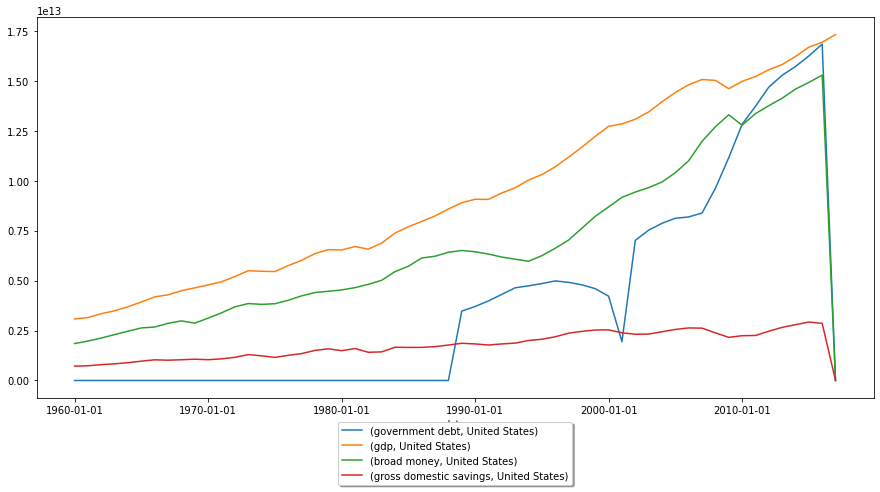

In [40]:
policy_plot_df = policy_features_df[['government debt', 'gdp', 'broad money', 'gross domestic savings']].unstack()
fig, ax = plt.subplots(figsize=(15,7))
policy_plot_df.iloc[:, policy_plot_df.columns.get_level_values(1).isin([country])].dropna().plot(kind='line', ax=ax)
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, shadow = True)

## Aggregate the variables

The indicator variables are mean-aggregated to create world-level values for each of the indicator variables.

#### Join the four groups of metaindicators to create a single feature set

In [41]:
base_feature_df = pd.concat([peoples_features_df, tech_features_df, trade_features_df, policy_features_df, population_df], axis=1).sort_index().fillna(0.00)

In [42]:
feature_df = base_feature_df[np.in1d(base_feature_df.index.get_level_values(1), [country])]

In [43]:
ratio_based_features = ['bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield', 'energy imports',
                        'food exports', 'high-tech exports', 'inflation', 'lending interest rate', 'life expectancy',
                        'population density', 'real interest rate']

In [44]:
ratio_df = feature_df[ratio_based_features]
ratio_df = ratio_df[np.in1d(ratio_df.index.get_level_values(1), [country])]
ratio_df = ratio_df.reset_index(level=1, col_level=0, drop=True)
ratio_df.columns = ratio_based_features
ratio_df.replace(0.00, np.nan, inplace=True)
ratio_feature_df = ratio_df.fillna(method='ffill').fillna(0.00)

In [45]:
gdp_based_features = ['gdp', 'broad money', 'exports of goods and services', 'gross domestic savings',
                      'high-tech value added', 'household consumption expenditure', 'housing expenditure', 
                      'health expenditure', 'education expenditure', 'leisure expenditure',
                      'imports of goods and services', 'listed companies', 'manufacturing value added',
                      'r and d spend',  'services trade', 'trade']

In [46]:
country_gdp_df = feature_df[gdp_based_features]
country_gdp_df = country_gdp_df[np.in1d(country_gdp_df.index.get_level_values(1), [country])]
country_gdp_df = country_gdp_df.reset_index(level=1, col_level=0, drop=True)
country_gdp_df.columns = gdp_based_features
country_gdp_df.replace(0.00, np.nan, inplace=True)
gdp_feature_df = country_gdp_df.iloc[:,1:].div(country_gdp_df.gdp, axis=0).fillna(method='ffill').fillna(0.00)

In [47]:
tax_based_features = ['government debt', 'government debt service', 'government interest payments external debt',
                      'government tax revenue']

In [48]:
tax_df = feature_df[tax_based_features]
tax_df = tax_df[np.in1d(tax_df.index.get_level_values(1), [country])]
tax_df = tax_df.reset_index(level=1, col_level=0, drop=True)
tax_df.columns = tax_based_features
tax_df.replace(0.00, np.nan, inplace=True)
tax_feature_df = tax_df.iloc[:,1:].div(tax_df['government tax revenue'], axis=0).fillna(method='ffill').fillna(0.00)

In [49]:
population_based_features = ['population', 'birth deaths', 'broadband subscriptions', 'electricity access',
                             'co2 emissions', 'electricity consumption', 'mobile subscriptions', 'newborns',
                             'overweight', 'rural population', 'urban population']

In [50]:
country_pop_df = feature_df[population_based_features]
country_pop_df = country_pop_df[np.in1d(country_pop_df.index.get_level_values(1), [country])]
country_pop_df = country_pop_df.reset_index(level=1, col_level=0, drop=True)
country_pop_df.columns = population_based_features
country_pop_df.replace(0.00, np.nan, inplace=True)
pop_feature_df = country_pop_df.iloc[:,1:].div(country_pop_df.population, axis=0).fillna(method='ffill').fillna(0.00)

In [51]:
country_feature_df = pd.concat([ratio_feature_df, gdp_feature_df, tax_feature_df, pop_feature_df], axis=1).sort_index().fillna(0.00)

In [52]:
country_feature_df.columns

Index(['bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'housing expenditure', 'health expenditure', 'education expenditure',
       'leisure expenditure', 'imports of goods and services',
       'listed companies', 'manufacturing value added', 'r and d spend',
       'services trade', 'trade', 'government debt service',
       'government interest payments external debt', 'government tax revenue',
       'birth deaths', 'broadband subscriptions', 'electricity access',
       'co2 emissions', 'electricity consumption', 'mobile subscriptions',
       'newborns', 'overweight', 'rural population', 'urban population'],
      dtype='obj

#### Export the variables

In [53]:
country_feature_df.to_csv('timeseries-transformer/%s_features.csv' % country, sep=';')